In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits as mp
import seaborn as sns
import src.make_data as generate
import src.plots as plot
import csv
from sklearn.ensemble import GradientBoostingClassifier
from src.model import Model
import src.pipeline as pipeline
from sklearn.metrics import log_loss

%matplotlib inline
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
df = pd.read_csv('data/merged_data.csv')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33486 entries, 0 to 33485
Data columns (total 37 columns):
fire_year           33486 non-null int64
discovery_date      33486 non-null float64
discovery_doy       33486 non-null int64
discovery_time      21081 non-null float64
stat_cause_code     33486 non-null float64
stat_cause_descr    33486 non-null object
cont_date           21338 non-null float64
cont_doy            21338 non-null float64
cont_time           20657 non-null float64
fire_size           33486 non-null float64
fire_size_class     33486 non-null object
latitude_x          33486 non-null float64
longitude_x         33486 non-null float64
state               33486 non-null object
county              23220 non-null object
fips_code           23220 non-null float64
fips_name           23220 non-null object
date_start          33486 non-null object
month_x             33486 non-null int64
date_end            21338 non-null object
length              21338 non-null float64
w

In [38]:
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'])


In [12]:
df['tmax'].loc[df['tmax'] > 150] = df['tmax'].loc[df['tmax'] > 150]/100


/Users/Maggie/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


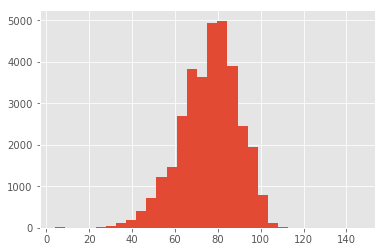

In [13]:
df['tmax'].hist(bins = 30)

### Cause of Fire EDA

In [23]:
def group_cause(cause):
    
    human_activity = ['Debris Burning', 'Campfire', 'Arson', 'Children', 'Fireworks', 'Smoking', 'Equipment Use']
    other = ['Missing/Undefined', 'Powerline', 'Railroad', 'Structure', 'Lightning', 'Miscellaneous']
    #nature = ['Lightning']
    
    if cause in human_activity: 
        return 'human'
    elif cause in other:
        return 'other'
    

In [24]:
df['cause_group'] = np.vectorize(group_cause)(df['stat_cause_descr'])

In [25]:
cause_groupby = df.groupby('stat_cause_descr')
cause_group_grouby = df.groupby('cause_group')

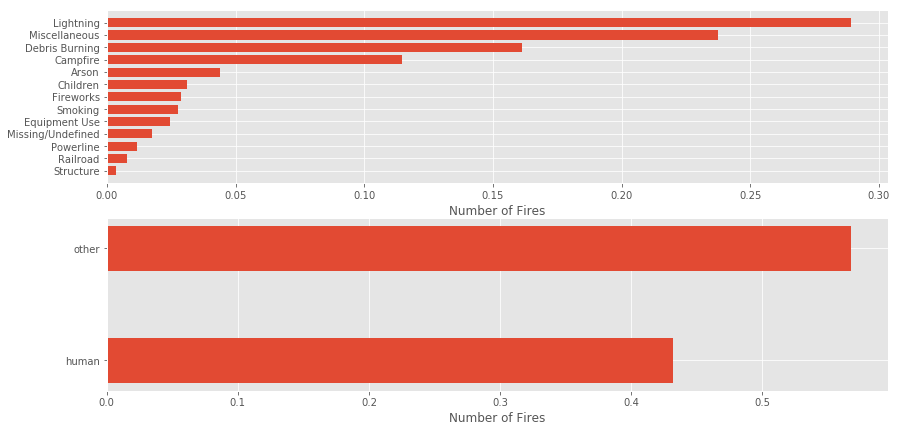

In [26]:
fig, axs = plt.subplots(2,1, figsize=(14,7))

cause_counts = cause_groupby.count().sort_values('fire_year', ascending=True)
total_fires = cause_counts.iloc[:,1].values.sum()
axs[0].barh(np.linspace(0,13,13), cause_counts['stat_cause_code']/total_fires, tick_label=cause_counts.index)
axs[0].set_xlabel('Number of Fires')

cause_group_counts = cause_group_grouby.count().sort_values('fire_year', ascending=True)
axs[1].barh(np.linspace(0,2,2), cause_group_counts['stat_cause_code']/total_fires, tick_label=cause_group_counts.index)
axs[1].set_xlabel('Number of Fires')


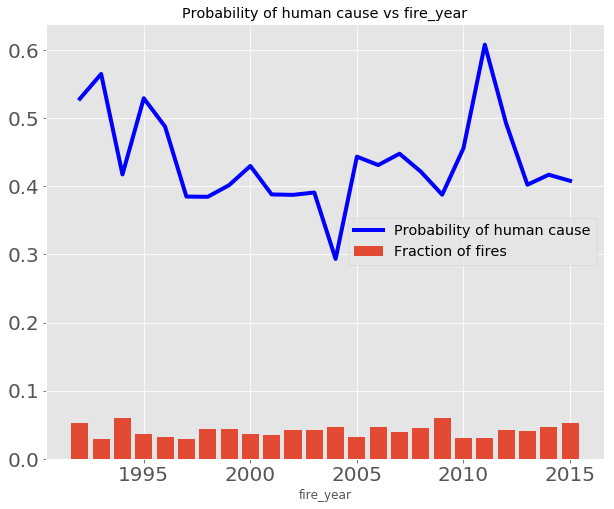

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
plot.univariate_plot('fire_year', ax, df)

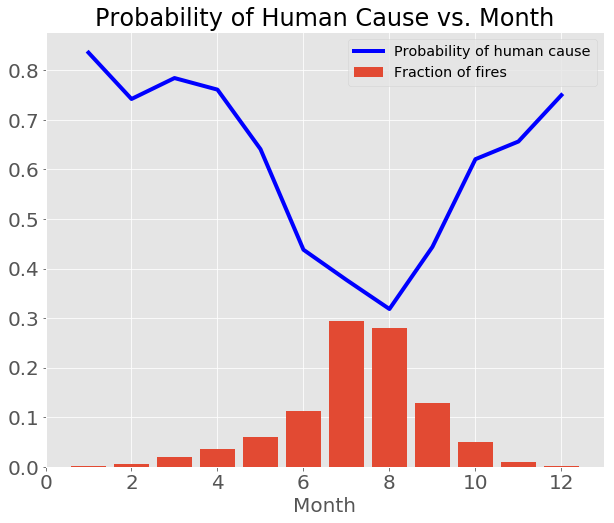

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
plot.univariate_plot('month_x', ax, df)
ax.set_title('Probability of Human Cause vs. Month', fontsize=24)
ax.set_xlabel('Month', fontsize=20)
fig.savefig('images/month_univariate')

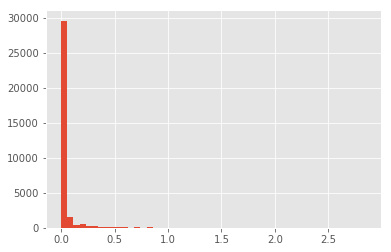

In [88]:
df['prcp'].hist(bins=50)

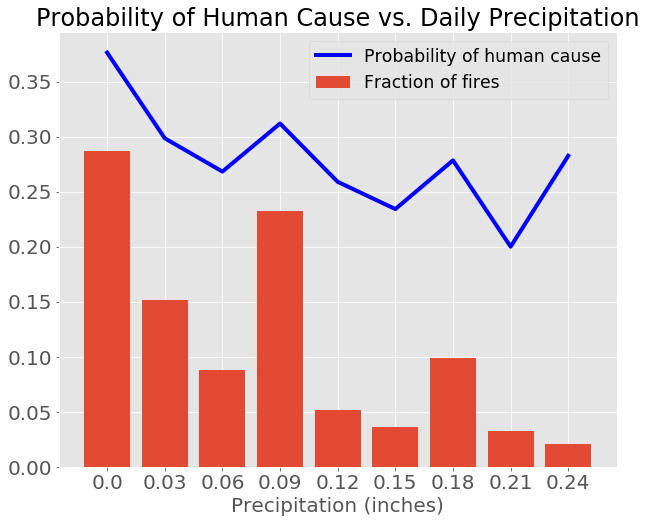

In [29]:
fig, ax = plt.subplots(figsize=(10,8))

prcp_bins = np.arange(0,0.3,0.03)
_ = plot.univariate_binned_plot(prcp_bins,'prcp', ax, df)

ax.set_title('Probability of Human Cause vs. Daily Precipitation', fontsize=24)
ax.set_xlabel('Precipitation (inches)', fontsize=20)
fig.savefig('images/prcp_univariate')

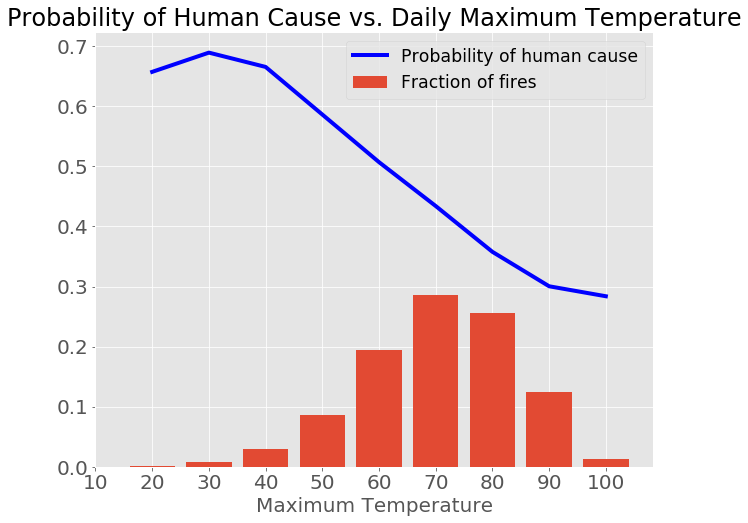

In [30]:
fig, ax = plt.subplots(figsize=(10,8))

tmax_bins = np.arange(10,120,10)
_ = plot.univariate_binned_plot(tmax_bins,'tmax', ax, df)

ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
ax.set_xlabel('Maximum Temperature', fontsize=20)
fig.savefig('images/tmax_univariate')


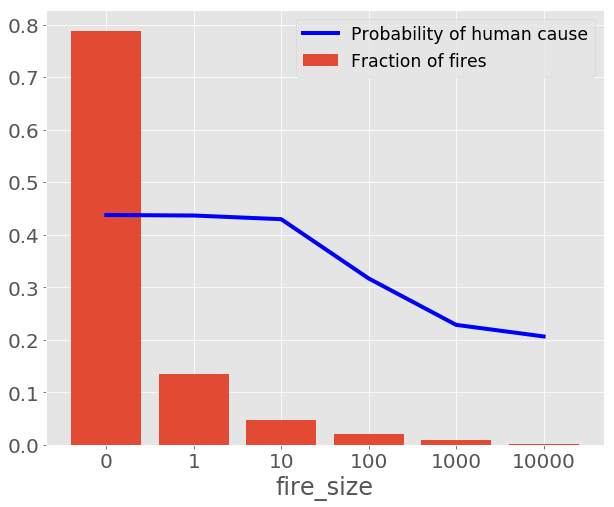

In [31]:
fig, ax = plt.subplots(figsize=(10,8))

fire_size_bins = np.array([0,1,10,100,1000,10000,30000])
_ = plot.univariate_binned_plot(fire_size_bins,'fire_size', ax, df)


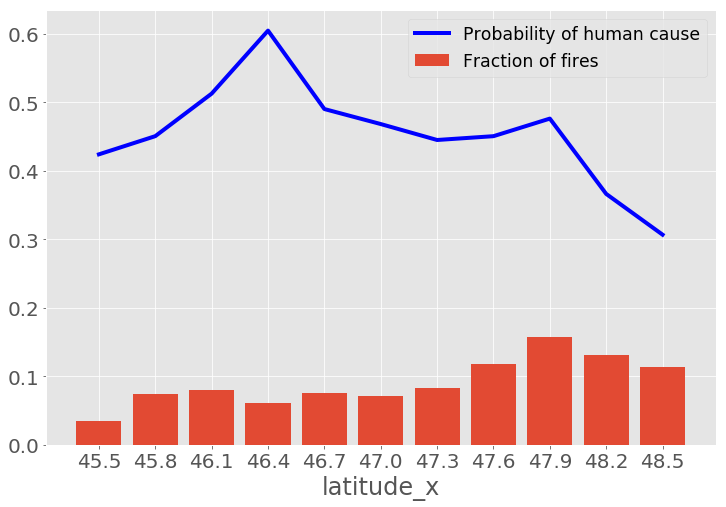

In [54]:
fig, ax = plt.subplots(figsize=(12,8))

lat_bins = np.arange(45.5,49, 0.3)
_ = plot.univariate_binned_plot(lat_bins,'latitude_x', ax, df)


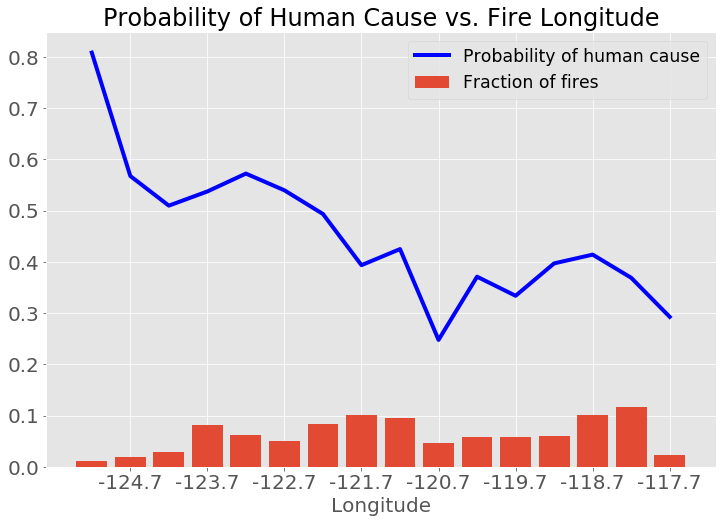

In [60]:
fig, ax = plt.subplots(figsize=(12,8))

long_bins = np.arange(-124.7,-116.5, 0.5)
_ = plot.univariate_binned_plot(long_bins,'longitude_x', ax, df)

ax.set_xticks(np.arange(1,len(long_bins), 2))
ax.set_xticklabels(np.arange(-124.7,-116.5, 1))
ax.set_title('Probability of Human Cause vs. Fire Longitude', fontsize=24)
ax.set_xlabel('Longitude', fontsize=20)
fig.savefig('images/longitude_univariate')

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

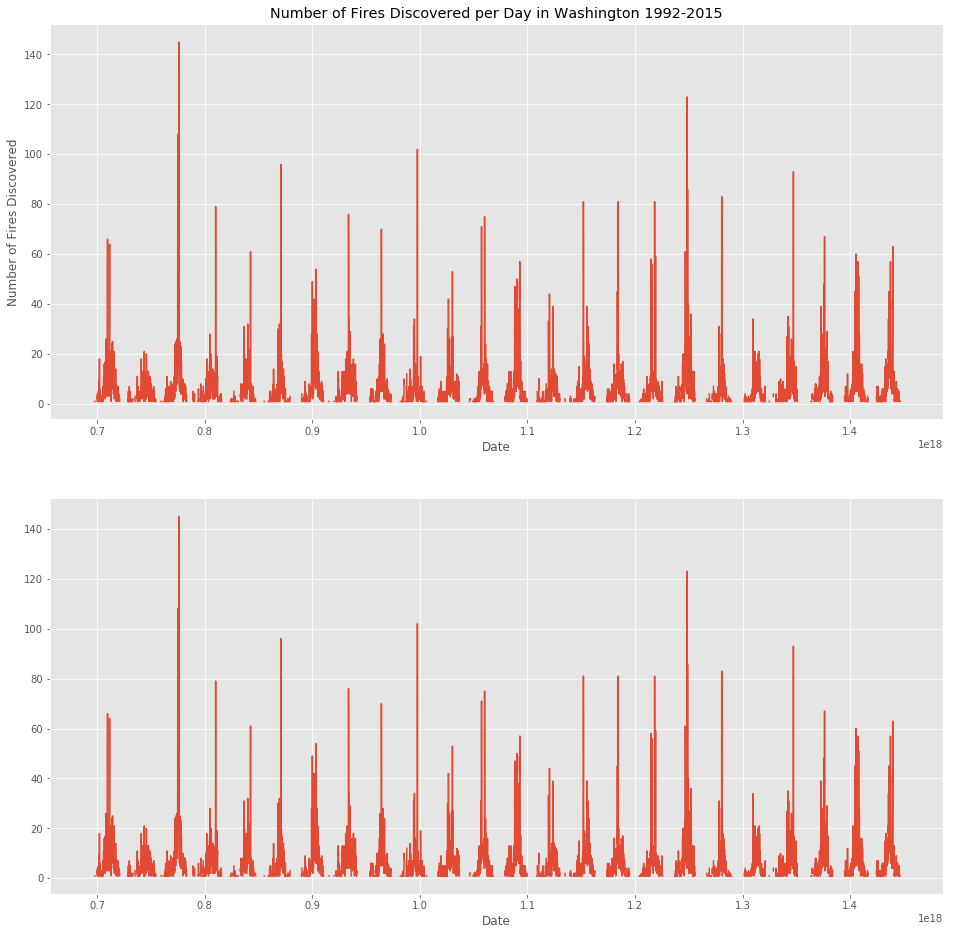

In [61]:
# Time series plots
index = pd.date_range(df["date_start"].min(), df["date_start"].max())
groupby_date = df.groupby("date_start")
count_timeseries = pd.Series(data = groupby_date['fire_year'].count(), index=index)

fig, axs = plt.subplots(2,1,figsize=(16,16))

axs[0].plot(count_timeseries.index, count_timeseries.values)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Number of Fires Discovered')
axs[0].set_title('Number of Fires Discovered per Day in Washington 1992-2015')

axs[1].plot(count_timeseries.index, count_timeseries.values)
axs[1].set_xlabel('Date')
axs[1].set_xlim((pd.Timestamp('2010-01-01 00:00:00'), pd.Timestamp('2015-11-27 00:00:00')))
#axs[1].set_xlim('2010-01-01 00:00:00', '2015-11-27 00:00:00')
axs[1].set_ylim(-5,50)
axs[1].set_ylabel('Number of Fires Discovered')
axs[1].set_title('Number of Fires Discovered per Day in Washington 2010-2015')


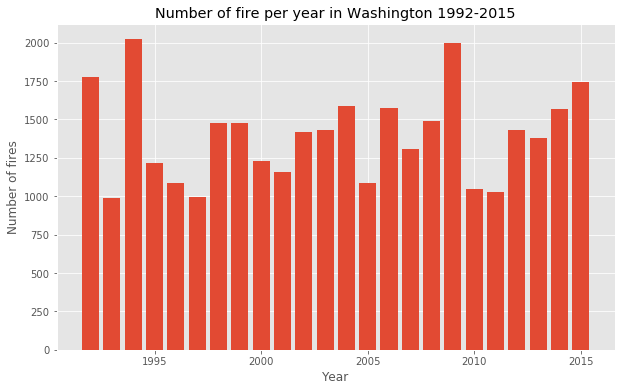

In [62]:
year_count = df.groupby('fire_year').count()['state']

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(year_count.index, year_count.values)
ax.set_xlabel('Year')
ax.set_ylabel('Number of fires')
ax.set_title("Number of fire per year in Washington 1992-2015")

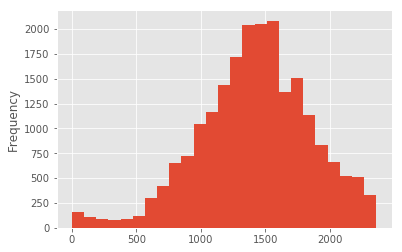

In [134]:
df['discovery_time'].plot(kind='hist', bins=25)

## Weather data

In [32]:
weather = pd.read_csv('data/clean_weather_data.csv')

In [33]:
weather.head()

,station,latitude,longitude,elevation,date,prcp,snow,snwd,tavg,tmax,tmin,tobs,month,year,doy
0,USW00094240,47.9375,-124.5550,56.4,1992-01-01,1.84,0.0,0.0,NaN,51.0,45.0,NaN,1,1992,1
1,USC00452914,47.9558,-124.3539,106.7,1992-01-01,0.58,0.0,0.0,NaN,51.0,46.0,46.0,1,1992,1
2,USC00451496,47.5711,-124.2922,24.4,1992-01-01,0.50,0.0,0.0,NaN,52.0,44.0,44.0,1,1992,1
3,USC00453320,46.8008,-124.0863,3.0,1992-01-01,0.00,0.0,0.0,NaN,54.0,46.0,47.0,1,1992,1
4,USC00454748,46.3675,-124.0377,7.6,1992-01-01,1.39,0.0,0.0,NaN,54.0,44.0,45.0,1,1992,1


### Aggregate Weather Data

In [34]:
group_station_month = weather.groupby(['station', 'month', 'year'])

In [35]:
monthly_total_prcp = group_station_month.sum()['prcp']

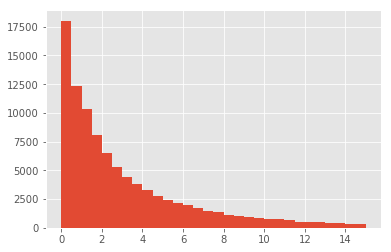

In [36]:
monthly_total_prcp[monthly_total_prcp < 15].hist(bins=30)

In [45]:
df.iloc[0]

fire_year                          2005
discovery_date              2.45354e+06
discovery_doy                       170
discovery_time                     1430
stat_cause_code                       1
stat_cause_descr              Lightning
cont_date                   2.45354e+06
cont_doy                            171
cont_time                          1400
fire_size                           0.3
fire_size_class                       B
latitude_x                      46.2208
longitude_x                    -117.785
state                                WA
county                               27
fips_code                            27
fips_name                  Grays Harbor
date_start          2005-06-19 00:00:00
month_x                               6
date_end            2005-06-20 00:00:00
length                                1
weather_station             USS0017C05S
station                     USS0017C05S
latitude_y                        46.12
longitude_y                     -117.85


In [61]:
def weather_feature(n_days, gap, col, station, date, metric='sum', weather=weather):
    temp_df = weather.loc[(weather['station']==station) 
                          & (weather['date'] < date-gap) & (weather['date'] > date-n_days-gap)]
    return temp_df[col].sum()
    

In [64]:
v_weather_feature = np.vectorize(weather_feature, excluded=['n_days', 'gap', 'col', 'metric', 'weather'])

In [ ]:
df['prcp_30_0'] = v_weather_feature(n_days, gap, col, df['station'], df['date_start'])

In [51]:
n_days = pd.to_timedelta('30 days')
gap = pd.to_timedelta('0 days')
col = 'prcp'
metric = 'sum'
station = 'USS0017C05S'
date = pd.to_datetime('2005-06-19 00:00:00')

In [54]:
temp_df = weather.loc[(weather['station']==station) & (weather['date'] < date) & (weather['date'] > date-n_days)]

In [58]:
temp_df[col].sum()

1.8

In [50]:
pd.to_timedelta('30 days')

Timedelta('30 days 00:00:00')

In [43]:
weather['date'] = pd.to_datetime(weather['date'])

In [ ]:
def get_weather(doy, year, station, weather=weather_sorted):
    return weather['tmax'].loc[(weather['station'] == station) &
                                (weather['year'] == year) &
                               (weather['doy'] == doy)]

In [ ]:
df_eda = pd.merge(df_eda, weather_sorted, how='left', left_on=['weather_station', 'fire_year', 'discovery_doy'],
                  right_on=['station', 'year', 'doy'])

In [ ]:
df_eda.head()

In [ ]:
weather_sorted['tmax'].loc[(weather_sorted['station'] == 'USR0000WFTA') &
                                (weather_sorted['year'] == 2014)
                              & (weather_sorted['doy'] == 1)].values

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
univariate_plot('tmax_fire_day', ax, df=df_eda)

### Model test

In [177]:
features = ["discovery_doy", "fire_size", "latitude_x",
                     "longitude_x", "elevation", "prcp", "snow", "tmax", "tmin"]

In [178]:
model = Model('gbc', n_estimators=100)

In [179]:
X, y = pipeline.get_model_features('data/merged_data.csv', features, 'cause_group', 'human')

In [180]:
model.cross_validate(5, X, y)

fold: 1, log-loss: 0.57
fold: 2, log-loss: 0.58
fold: 3, log-loss: 0.57
fold: 4, log-loss: 0.57
fold: 5, log-loss: 0.57


([0.57487490879965486,
  0.57638408696674803,
  0.57029281706720669,
  0.57390894421648131,
  0.57319458755102526],
 [],
 [],
 [])

In [142]:
mean = y.mean()

In [145]:
mean_pred = np.array([mean]*y.shape[0])

In [148]:
log_loss(y, mean_pred)

0.68389807489019738

In [1]:
import simplejson
import sys
import yaml


In [2]:
yaml.dump('config.json')

'config.json\n...\n'

In [9]:
with open ('config.json') as f: 
    with open ('config.yaml', 'w') as f2:
        f2.write(yaml.dump(simplejson.load(f), default_flow_style=False))


In [11]:
fire_raw = pd.read_csv('data/WA_fires.csv')

In [12]:
fire_raw.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,2005,2453540.5,170,1430.0,1.0,Lightning,2453541.5,171.0,1400.0,0.3,B,46.220833,-117.785000,WA,27,27.0,Grays Harbor
1,2005,2453567.5,197,1354.0,4.0,Campfire,2453567.5,197.0,1600.0,0.1,A,46.080556,-117.890833,WA,13,13.0,Columbia
2,2005,2453516.5,146,950.0,6.0,Railroad,2453516.5,146.0,1020.0,0.1,A,45.665000,-121.203611,WA,39,39.0,Klickitat
3,2005,2453585.5,215,1236.0,9.0,Miscellaneous,2453585.5,215.0,1402.0,0.1,A,48.356667,-117.060833,WA,51,51.0,Pend Oreille
4,2005,2453555.5,185,2002.0,6.0,Railroad,2453555.5,185.0,2010.0,0.1,A,45.699444,-121.413611,WA,39,39.0,Klickitat


In [17]:
test_data = fire_raw.sample(5)

In [26]:
pd.read_csv('data/test_clean.csv')

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,prcp,snow,snwd,tavg,tmax,tmin,tobs,month_y,year,doy
0,1993,2449120.5,133,1701.0,5.0,Debris Burning,2449120.5,133.0,1930.0,30.0,...,0.00,0.0,0.0,NaN,91.0,56.0,63.0,5,1993,133
1,2010,2455406.5,210,NaN,1.0,Lightning,NaN,NaN,NaN,0.1,...,1.31,0.0,0.0,NaN,81.0,44.0,NaN,7,2010,210
2,1992,2448906.5,285,NaN,9.0,Miscellaneous,NaN,NaN,NaN,5.0,...,0.00,0.0,0.0,NaN,64.0,50.0,59.0,10,1992,285
3,1998,2451056.5,243,NaN,9.0,Miscellaneous,NaN,NaN,NaN,0.1,...,0.00,0.0,0.0,NaN,100.0,52.0,78.0,8,1998,243
4,2014,2456871.5,214,1742.0,11.0,Powerline,2456879.5,222.0,1800.0,0.5,...,0.00,0.0,0.0,NaN,90.0,57.0,NaN,8,2014,214


In [29]:
predictions = pd.read_csv('data/predictions.csv')

In [31]:
predictions.head(2).to_dict()

{'date_start': {0: '1993-05-13', 1: '1992-10-11'},
 'latitude_x': {0: 47.8582, 1: 47.6031},
 'longitude_x': {0: -118.0594, 1: -120.19421000000001},
 'prediction': {0: 0.7135056665999614, 1: 0.6140373672145029}}